# Loading in xray data from exp (55Fe x-rays on SCA 20663)

In [1]:
# Turn ON notebook and OFF inline and ipympl when running on OSC
%matplotlib notebook  
#%matplotlib inline 
#%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.optimize as opt
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.ndimage import maximum_filter
from scipy.ndimage import binary_dilation
from astropy.stats import sigma_clipped_stats
from matplotlib.patches import Polygon, Rectangle
from scipy.ndimage import binary_dilation, label, center_of_mass
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.ndimage import label
from pathlib import Path

try:
    here = Path(__file__).parent
except NameError:
    # __file__ doesn't exist in notebooks or interactive sessions
    here = Path.cwd()
fits_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'  # ← replace with your actual filename

with fits.open(fits_path) as hdulist:
    # hdulist is a list of HDU (Header/Data Unit) objects
    primary_hdu = hdulist[0]
    data = primary_hdu.data      # NumPy array of your image/spectrum/whatever
    header = primary_hdu.header  # FITS header metadata

print(f"Data shape: {data.shape}")
print("Header keys:", list(header.keys())[:10])


Data shape: (100, 4096, 4096)
Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND']


In [2]:
#enter number of available cores
num_of_cores = os.cpu_count() + 4

#X-ray energy (in eV)
xray_en = 5898.75

#data dimensions
Nframe, h, w = data.shape

def compute_mask_med_frame(data, sigma_mult):
    print("⏳ Finding hot pixels…")
    median_img = np.median(data, axis=0)
    mad        = np.median(np.abs(median_img - np.median(median_img)))
    sigma_est  = 1.4826 * mad
    thresh_med = np.median(median_img) + sigma_mult * sigma_est
    mask_med   = median_img > thresh_med
    print(f"✅ Done looking for hot pixels (σ={sigma_est:.3f}, thresh={thresh_med:.1f})")
    return mask_med

def compute_mask_first_frame(data, sigma_mult):
    print("⏳ Finding very hot pixels…")
    first_img  = data[0]
    med_first  = np.median(first_img)
    mad_first  = np.median(np.abs(first_img - med_first))
    sigma_est  = 1.4826 * mad_first
    thresh0    = med_first + sigma_mult * sigma_est
    mask0      = first_img > thresh0
    print(f"✅ Done looking for very hot pixels (σ={sigma_est:.3f}, thresh={thresh0:.1f})")
    return mask0

def compute_mask_no_response(data, sat_cut):
    print("⏳ Finding non-responsive pixels…")
    # If you wanted a row-wise tqdm you could replace the next line with a loop + tqdm
    frame_diff = np.abs(np.diff(data, axis=0))       # (Nframe-1, 4096,4096)
    med_diff   = np.median(frame_diff, axis=0)
    mask_non_res   = med_diff < sat_cut
    print(f"✅ Done looking for non-responsive pixesls (median(med_diff)={np.median(med_diff):.3e})")
    return mask_non_res

# parameters
sigma_mult = 9.8
sat_cut     = 5.999

print(f"Number of cores available for parallelization = {num_of_cores - 4}")
# launch all three in parallel
with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    futures = {
        exe.submit(compute_mask_med_frame,  data, sigma_mult): 'med',
        exe.submit(compute_mask_first_frame, data, sigma_mult): 'first',
        exe.submit(compute_mask_no_response, data, sat_cut):     'sat',
    }
    # just iterate to let each print when done
    for fut in as_completed(futures):
        _name = futures[fut]
        # could inspect fut.result() here if you wanted to check for errors

mask_hot = [f for f,n in futures.items() if n=='med'][0].result()
mask_veryhot  = [f for f,n in futures.items() if n=='first'][0].result()
mask_non_res = [f for f,n in futures.items() if n=='sat'][0].result()

print("🔗 Combining masks into one boolean array…")
base_mask = mask_hot | mask_veryhot | mask_non_res

# create a mask for pixels adjacent to a pixel with flagged response: any neighbor of the base_mask
print("⏳ Finding all adjacent pixels…")
mask_adj  = binary_dilation(base_mask, structure=np.ones((3,3)), border_value=0) & ~base_mask
maskArray = base_mask | mask_adj
print("✅ Done with adjacent pixel mask")

print("🔗 Combining all masks into final array…")
print("🎉 maskArray ready, shape =", maskArray.shape)

print("Comparing to percentages from Hirata, 2024, Table 2:")
# fractions in percent
frac_non_res   = mask_non_res.mean()   * 100  # mask.mean() = mask.sum() / mask.size
frac_hot   = mask_hot.mean()   * 100  
frac_veryhot = mask_veryhot.mean()       * 100  
frac_adj = mask_adj.mean() * 100
frac_all   = maskArray.mean()   * 100  # union 

print(f"Non-resp pixels: {frac_non_res:.2f}% (vs. 0.53% in literature)")
print(f"Hot pixels: {frac_hot:.2f}% (vs. 0.20% in literature)")
print(f"Very hot pixels: {frac_veryhot:.2f}% (vs. 0.11% in literature)")
print(f"Adjacent pixels: {frac_adj:.2f}% (vs. 2.47% in literature)")
print(f"Union:       {frac_all:.2f}%  (vs. 3.01% in literature)")

Number of cores available for parallelization = 40
⏳ Finding hot pixels…
⏳ Finding very hot pixels…
⏳ Finding non-responsive pixels…
✅ Done looking for very hot pixels (σ=8.896, thresh=86.2)
✅ Done looking for non-responsive pixesls (median(med_diff)=1.000e+01)
✅ Done looking for hot pixels (σ=0.741, thresh=7.3)
🔗 Combining masks into one boolean array…
⏳ Finding all adjacent pixels…
✅ Done with adjacent pixel mask
🔗 Combining all masks into final array…
🎉 maskArray ready, shape = (4096, 4096)
Comparing to percentages from Hirata, 2024, Table 2:
Non-resp pixels: 0.38% (vs. 0.53% in literature)
Hot pixels: 0.40% (vs. 0.20% in literature)
Very hot pixels: 0.11% (vs. 0.11% in literature)
Adjacent pixels: 3.10% (vs. 2.47% in literature)
Union:       3.90%  (vs. 3.01% in literature)


Number of very hot pixels =  17769
Number of hot pixels =  66476
Number of non-responsive pixels =  64482
Number of adjacent pixels =  520563
Total number of unusable pixels =  654888


<IPython.core.display.Javascript object>


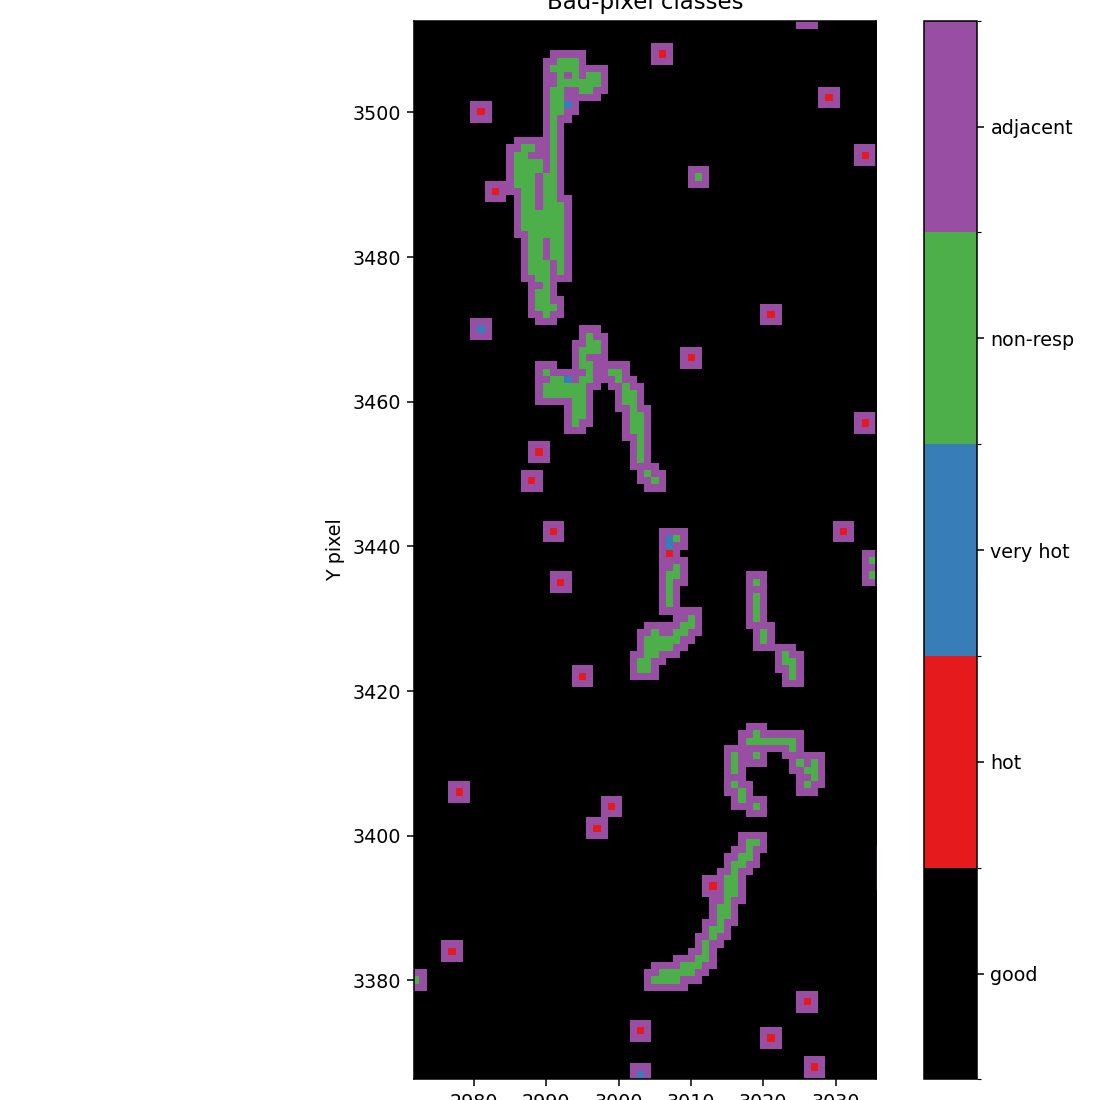

In [3]:
very_hot_pix = np.count_nonzero(mask_veryhot)
hot_pix = np.count_nonzero(mask_hot)
non_res_pix = np.count_nonzero(mask_non_res)
adj_pix = np.count_nonzero(mask_adj)
all_bad_pix = np.count_nonzero(maskArray)

print("Number of very hot pixels = ", very_hot_pix)
print("Number of hot pixels = ", hot_pix)
print("Number of non-responsive pixels = ", non_res_pix)
print("Number of adjacent pixels = ", adj_pix)
print("Total number of unusable pixels = ", all_bad_pix)

labels = np.zeros((h, w), dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 = good pixels (black) 
    "#e41a1c",  # 1 = hot         (red)
    "#377eb8",  # 2 = very hot    (blue)
    "#4daf4a",  # 3 = non-resp    (green)
    "#984ea3",  # 4 = adjacent    (purple)
])
# make boundaries at ints 0–5
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

plt.figure(figsize=(8, 8))
im = plt.imshow(labels, origin="lower", cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels([
    "good", "hot", "very hot", "non-resp", "adjacent"
])
plt.title("Bad-pixel classes")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.tight_layout()
plt.show()

Found 37174 xray & cosmic‐ray‐like peaks with ≥6.0 σ cut (per-frame thresholds below):


<IPython.core.display.Javascript object>


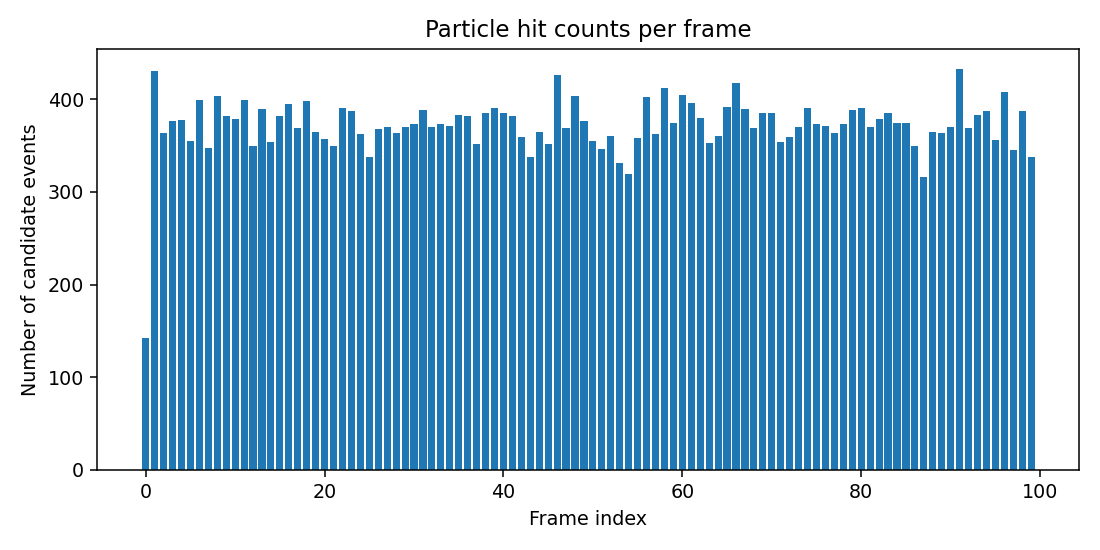

In [5]:
sigma_thresh   = 6.01
mask_expanded  = maximum_filter(maskArray.astype(int), size=5) > 0

def find_peaks_for_frame(iframe, sigma_thresh):
    image   = data[iframe]
    _, med, _ = sigma_clipped_stats(image, sigma=3.0, maxiters=5)
    mad     = np.median(np.abs(image - med))
    sigma_e = mad * 1.4826
    threshold = med + sigma_thresh * sigma_e

    local_max = maximum_filter(image, size=3)
    cand      = (image == local_max) & (~mask_expanded) & (image > threshold)

    ys, xs = np.where(cand)
    peaks  = [(iframe, int(y), int(x)) for y, x in zip(ys, xs)]
    return peaks, threshold

if __name__ == "__main__":

    # 1) run in parallel, get a list of (peaks, threshold) tuples
    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        results = list(executor.map(
            find_peaks_for_frame,
            range(Nframe),
            [sigma_thresh] * Nframe
        ))

    # 2) unzip them into two lists
    all_frame_peaks, thresholds = zip(*results)
    #    all_frame_peaks is a tuple of length Nframe, each entry is the peaks list
    #    thresholds        is a tuple of length Nframe, each entry is that frame’s threshold

    # 3) now do your “previous‐frame” filtering exactly as before
    filtered_events = []
    for f, peaks in enumerate(all_frame_peaks):
        prev_f = (f - 1) % Nframe
        prev_pos = {(y, x) for (_, y, x) in all_frame_peaks[prev_f]}
        for (_, y, x) in peaks:
            if (y, x) not in prev_pos:
                filtered_events.append((f, y, x))

    events = np.array(filtered_events, dtype=int)
    print(f"Found {len(events)} xray & cosmic‐ray‐like peaks "
          f"with ≥{sigma_thresh:.1f} σ cut (per-frame thresholds below):")

    # 4) if you want, print out each frame’s threshold:
    #for f, thr in enumerate(thresholds):
        #print(f"  frame {f:3d}: threshold = {thr:.1f}")

        # count how many hits in each frame
counts = np.bincount(events[:,0], minlength=data.shape[0])

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(counts)), counts)
plt.xlabel("Frame index")
plt.ylabel("Number of candidate events")
plt.title("Particle hit counts per frame")
plt.tight_layout()
plt.show()

In [6]:
def merge_peaks(events, data, proximity_radius=2, max_workers=num_of_cores):
    """
    Merge spatially adjacent peaks within each frame.

    Parameters
    ----------
    events : (M, 3)-ndarray of int
        List of (frame, y, x) peaks you've already found.
    data : ndarray, shape (Nframe, h, w)
        Your full data cube, needed for intensity weighting.
    proximity_radius : int
        Merge any two peaks whose pixel-centers are within
        `proximity_radius` in Chebyshev distance.

    Returns
    -------
    merged : (K,3)-ndarray of int
        New list of (frame, y, x), one per merged object.
    """

    # Pre-bucket original peaks by frame for O(1) lookup
    events_by_frame = {
        f: events[events[:,0] == f, 1:]
        for f in np.unique(events[:,0])
    }

    # A 3×3 struct for the actual label() call
    small_struct = np.ones((3,3), dtype=bool)
    # The large footprint we use for dilation
    big_struct   = np.ones((2*proximity_radius+1,
                            2*proximity_radius+1), dtype=bool)

    def process_frame(f):
        coords = events_by_frame.get(f)
        if coords is None or len(coords)==0:
            return []

        # build a 1-pixel mask of your raw hits
        mask = np.zeros((h, w), bool)
        mask[coords[:,0], coords[:,1]] = True

        # dilate by the big_struct so any hits within r pixels merge
        mask_dil = binary_dilation(mask, structure=big_struct)

        # now label the dilated mask with the 3×3 struct
        labeled, ncomp = label(mask_dil, structure=small_struct)

        # figure out which original coords belong to which label
        labels_at_peaks = labeled[coords[:,0], coords[:,1]]

        merged = []
        for lab in range(1, ncomp+1):
            inds = np.where(labels_at_peaks == lab)[0]
            cluster = coords[inds]   # all (y,x) in this cluster

            if len(cluster)==1:
                y0, x0 = cluster[0]
            else:
                # intensity‐weighted centroid over the ORIGINAL points
                ys = cluster[:,0].astype(float)
                xs = cluster[:,1].astype(float)
                ws = data[f, ys.astype(int), xs.astype(int)].astype(float)
                y0 = int(round(np.average(ys, weights=ws)))
                x0 = int(round(np.average(xs, weights=ws)))

            merged.append((f, y0, x0))

        return merged

    # dispatch in parallel
    merged = []
    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        for sub in exe.map(process_frame, range(Nframe)):
            merged.extend(sub)

    return np.array(merged, dtype=int)

merged_events = merge_peaks(events, data)
events_difference = len(events) -len(merged_events)

print(f"{len(events)} → {len(merged_events)} merged events, a difference of {events_difference}")

37174 → 36946 merged events, a difference of 228


<IPython.core.display.Javascript object>


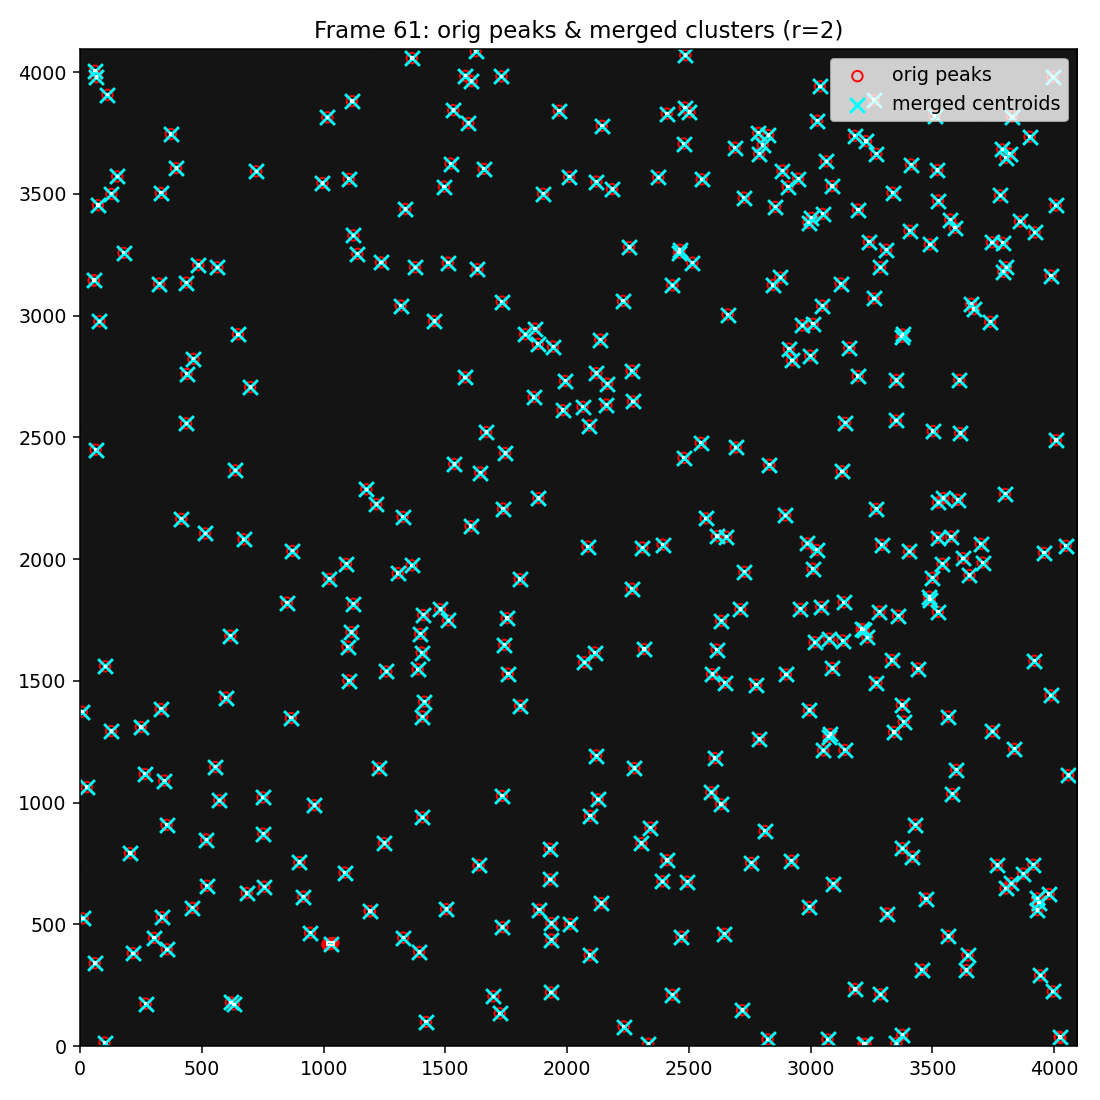

In [7]:
def plot_mergers(frame, events, merged_events, data, proximity_radius=2):
    """
    Show original peaks vs. merged clusters for a single frame,
    drawing red circles on the raw hits, cyan x’s at merged centroids,
    and white rectangles around each dilated cluster (r=proximity_radius).
    """
    img = data[frame]

    # 1) pick out this frame’s original and merged points
    orig   = events[events[:,0] == frame][:, 1:]
    merged = merged_events[merged_events[:,0] == frame][:, 1:]

    # 2) build a 1-pixel mask of the raw hits
    mask = np.zeros((h, w), dtype=bool)
    for y, x in orig:
        mask[y, x] = True

    # 3) dilate by your big footprint
    big_struct = np.ones((2*proximity_radius+1,
                          2*proximity_radius+1), dtype=bool)
    mask_dil = binary_dilation(mask, structure=big_struct)

    # 4) label that dilated mask with a 3×3 struct
    small_struct = np.ones((3,3), dtype=bool)
    labeled, ncomp = label(mask_dil, structure=small_struct)

    # 5) plot background
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img, cmap='gray', origin='lower')

    # 6) overlay raw peaks
    if len(orig):
        ys, xs = orig[:,0], orig[:,1]
        ax.scatter(xs, ys,
                   s=30, facecolors='none', edgecolors='red',
                   label='orig peaks')

    # 7) overlay merged centroids
    if len(merged):
        ym, xm = merged[:,0], merged[:,1]
        ax.scatter(xm, ym,
                   s=60, marker='x', color='cyan',
                   label='merged centroids')

    # 8) draw white rectangles around each dilated cluster
    for lab in range(1, ncomp+1):
        coords = np.argwhere(labeled == lab)
        y0, y1 = coords[:,0].min(), coords[:,0].max()
        x0, x1 = coords[:,1].min(), coords[:,1].max()
        width  = x1 - x0 + 1
        height = y1 - y0 + 1

        rect = Rectangle((x0, y0),
                         width, height,
                         fill=False,
                         edgecolor='white',
                         linewidth=1)
        ax.add_patch(rect)

    ax.set_title(f'Frame {frame}: orig peaks & merged clusters (r={proximity_radius})')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_mergers(frame=61, events=events, merged_events=merged_events, data=data)    

<IPython.core.display.Javascript object>


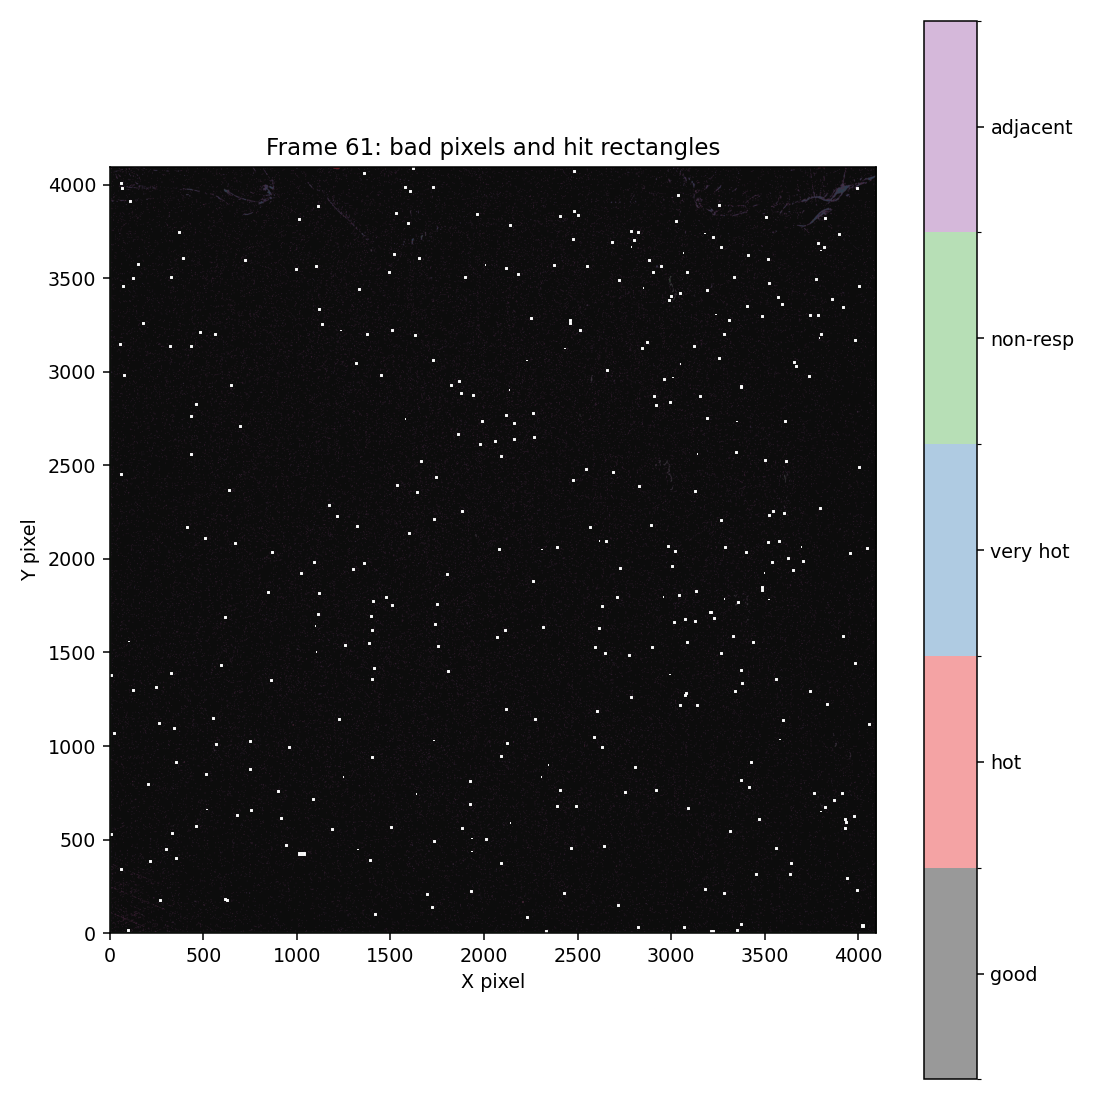

In [8]:
frame = 61
proximity_radius = 2

# 1) Build the labels array for the mask classes
labels = np.zeros((h, w), dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

# 2) Set up the colormap and normalization
cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 = good pixels
    "#e41a1c",  # 1 = hot
    "#377eb8",  # 2 = very hot
    "#4daf4a",  # 3 = non-resp
    "#984ea3",  # 4 = adjacent
])
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

# 3) Compute the dilation-based clusters for this frame’s peaks
coords = events[events[:,0] == frame][:, 1:]
mask_peaks = np.zeros((h, w), dtype=bool)
mask_peaks[coords[:,0], coords[:,1]] = True

big_struct = np.ones((2*proximity_radius+1, 2*proximity_radius+1), dtype=bool)
dilated = binary_dilation(mask_peaks, structure=big_struct)
labeled, ncomp = label(dilated, structure=np.ones((3,3), dtype=bool))

# 4) Plot and overlay
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data[frame], cmap='gray', origin='lower')
im = ax.imshow(labels, origin="lower", cmap=cmap, alpha = 0.4, norm=norm)
cbar = fig.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5], ax=ax)
cbar.ax.set_yticklabels(["good", "hot", "very hot", "non-resp", "adjacent"])

for lab in range(1, ncomp+1):
    pix = np.argwhere(labeled == lab)
    y0, y1 = pix[:,0].min(), pix[:,0].max()
    x0, x1 = pix[:,1].min(), pix[:,1].max()
    rect = Rectangle((x0, y0), x1-x0+1, y1-y0+1,
                     fill=False, edgecolor='white', linewidth=1)
    ax.add_patch(rect)

ax.set_title(f"Frame {frame}: bad pixels and hit rectangles")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


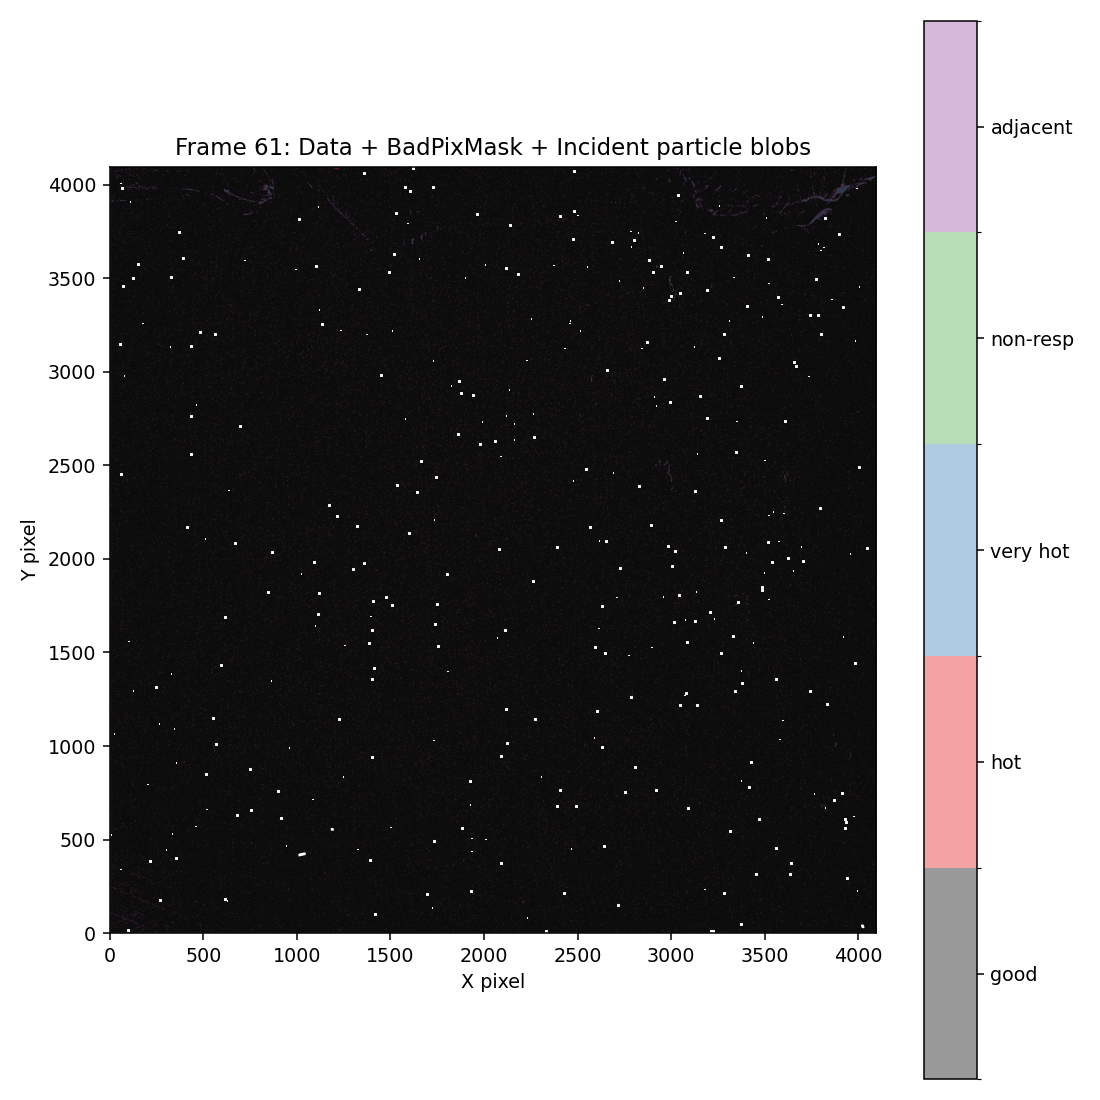

In [9]:
# parameters
frame = 61
proximity_radius = 2

# — build your 4-class mask label image as before —
labels = np.zeros((h, w),     dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 good
    "#e41a1c",  # 1 hot
    "#377eb8",  # 2 very hot
    "#4daf4a",  # 3 non-resp
    "#984ea3",  # 4 adjacent
])
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

# — reconstruct your dilated clusters for this frame —
orig = events[events[:,0] == frame][:,1:]   # (y,x) of raw hits
mask_peaks = np.zeros((h,w), bool)
mask_peaks[orig[:,0], orig[:,1]] = True

big_struct = np.ones((2*proximity_radius+1,)*2, dtype=bool)
mask_dil   = binary_dilation(mask_peaks, structure=big_struct)

# now label that with a 3×3
labeled, ncomp = label(mask_dil, structure=np.ones((3,3), bool))

# — plot everything —
fig, ax = plt.subplots(figsize=(8,8))

# 1) raw data
ax.imshow(data[frame], cmap='gray', origin='lower')

# 2) mask classes, semi-transparent
im = ax.imshow(labels, origin='lower', cmap=cmap, norm=norm, alpha=0.4)
cbar = fig.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5], ax=ax)
cbar.ax.set_yticklabels(["good","hot","very hot","non-resp","adjacent"])

# 3) convex‐hull blobs (or tiny boxes for 1–2 pixel clusters)
for lab in range(1, ncomp+1):
    pts = np.argwhere(labeled == lab)  # array of [[y,x],...]
    if len(pts) >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]      # still [[y,x],...]
        # flip to (x,y) for plotting
        poly = Polygon(hull_pts[:, ::-1],
                       fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(poly)
    else:
        # fallback box
        y0, y1 = pts[:,0].min(), pts[:,0].max()
        x0, x1 = pts[:,1].min(), pts[:,1].max()
        rect = Rectangle((x0, y0),
                         x1-x0+1, y1-y0+1,
                         fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(rect)

ax.set_title(f"Frame {frame}: Data + BadPixMask + Incident particle blobs")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
plt.tight_layout()
plt.show()


In [10]:
# Freudenburg et al. gain
gain = 1.6232  # electrons per DN

def prep_frame(f, min_size=2):
    """
    Compute median background, sigma_est, and a labels_fp
    """
    img = data[f].astype(np.float64)
    _, med, _  = sigma_clipped_stats(img, sigma=3.0, maxiters=15)
    mad        = np.median(np.abs(img - med))
    sigma_est  = mad * 1.4826
    thresh     = med + sigma_thresh * sigma_est

    # 1) make a binary mask of everything above threshold
    binary = img > thresh

    # 2) label connected components in that mask
    labels_tmp, n_comp = label(binary)

    # 3) figure out how big each component is
    #    bincount index i == number of pixels labeled 'i'
    counts = np.bincount(labels_tmp.ravel())
    #    we want to keep labels whose count >= min_size
    keep   = np.where(counts >= min_size)[0]

    # 4) build a "clean" boolean mask of just those kept pixels
    #    (np.isin will be True wherever labels_tmp is in keep)
    clean = np.isin(labels_tmp, keep)

    # 5) relabel the cleaned mask so you have 1,2,3… again
    labels_fp, _ = label(clean)

    return f, med, labels_fp


def process_hit(hit):
    """Given one (f, y, x) hit, compute all sums and return a dict."""
    f, y, x      = hit
    img          = data[f].astype(np.int32)
    med          = medians[f]
    labels_fp    = labels_list[f]

    # 3×3 window
    y0,  y1     = max(y-1,0), min(y+2,h)
    x0,  x1     = max(x-1,0), min(x+2,w)
    sum3        = img[y0:y1, x0:x1].sum()

    # 5×5 window
    y0_5, y1_5 = max(y-2,0), min(y+3,h)
    x0_5, x1_5 = max(x-2,0), min(x+3,w)
    sum5        = img[y0_5:y1_5, x0_5:x1_5].sum()

    # footprint sum
    lab = labels_fp[y, x]
    if lab == 0:
        # no cleaned footprint under this peak:
        sum_fp_DN = 0
        n_pix_fp  = 0
    else:
        region    = (labels_fp == lab)
        sum_fp_DN = img[region].sum() - med * region.sum()
        n_pix_fp  = int(region.sum())

    return {
        'frame':      f,
        'y':          y,
        'x':          x,
        'sum3x3_DN':  int(sum3),
        'sum3x3_e⁻':  sum3 * gain,
        'sum5x5_DN':  int(sum5),
        'sum5x5_e⁻':  sum5 * gain,
        'fp_label':   lab,
        'fp_DN':      int(sum_fp_DN),
        'fp_e⁻':      sum_fp_DN * gain,
        'n_pix_fp':   n_pix_fp,
    }

if __name__ == '__main__':
    # 1) Parallel frame prep
    medians     = np.zeros(Nframe, dtype=float)
    labels_list = [None] * Nframe

    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        futures = [executor.submit(prep_frame, f) for f in range(Nframe)]
        for fut in as_completed(futures):
            f, med, labels_fp = fut.result()
            medians[f]    = med
            labels_list[f] = labels_fp

    # 2) Parallel hit processing
    rows = []
    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        # adjust n_workers = os.cpu_count() if you like
        for result in executor.map(process_hit, events):
            rows.append(result)

    # 3) Build DataFrame & plot
    df = pd.DataFrame(rows)
    print(df.head())


   frame    y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  fp_label  \
0      0   10  3225        123   199.6536        141   228.8712         0   
1      0   16  3403         89   144.4648         61    99.0152         0   
2      0   71  3431         64   103.8848         99   160.6968         0   
3      0   95  2441         20    32.4640         65   105.5080         0   
4      0  100  1420         26    42.2032        -30   -48.6960         0   

   fp_DN  fp_e⁻  n_pix_fp  
0      0    0.0         0  
1      0    0.0         0  
2      0    0.0         0  
3      0    0.0         0  
4      0    0.0         0  


In [22]:
#print(df.head(200))

     frame    y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  fp_label  \
0        0   10  3225        123   199.6536        141   228.8712         0   
1        0   16  3403         89   144.4648         61    99.0152         0   
2        0   71  3431         64   103.8848         99   160.6968         0   
3        0   95  2441         20    32.4640         65   105.5080         0   
4        0  100  1420         26    42.2032        -30   -48.6960         0   
..     ...  ...   ...        ...        ...        ...        ...       ...   
195      1  508  3274       1631  2647.4392       1641  2663.6712         1   
196      1  516   465       1390  2256.2480       1297  2105.2904         1   
197      1  553   613       1510  2451.0320       1511  2452.6552         1   
198      1  554  1530       1345  2183.2040       1408  2285.4656         1   
199      1  560  3497       1393  2261.1176       1356  2201.0592         1   

        fp_DN         fp_e⁻  n_pix_fp  
0          

In [12]:
from scipy.ndimage import sum as ndi_sum

# -----------------------------------------------------------------------------
# 0) your existing definitions
# -----------------------------------------------------------------------------
gain            = 1.6232   # electrons per DN
sigma_thresh    = 5.0      # whatever you were using
num_of_cores    = os.cpu_count()
Nframe, h, w    = data.shape

def prep_frame(f, min_size=2):
    img = data[f].astype(np.float64)
    _, med, _  = sigma_clipped_stats(img, sigma=3.0, maxiters=15)
    mad        = np.median(np.abs(img - med))
    sigma_est  = mad * 1.4826
    thresh     = med + sigma_thresh * sigma_est

    binary     = img > thresh
    labels_tmp, _ = label(binary)
    counts     = np.bincount(labels_tmp.ravel())
    keep       = np.where(counts >= min_size)[0]
    clean      = np.isin(labels_tmp, keep)
    labels_fp, _ = label(clean)
    return f, med, labels_fp

# 1) Parallel‐compute your medians[] and footprint labels_list[]
medians     = np.zeros(Nframe, dtype=float)
labels_list = [None] * Nframe

with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    futures = [exe.submit(prep_frame, f) for f in range(Nframe)]
    for fut in as_completed(futures):
        f, med, labels_fp = fut.result()
        medians[f]        = med
        labels_list[f]    = labels_fp

# -----------------------------------------------------------------------------
# 2) Build an index of which events live in each frame
# -----------------------------------------------------------------------------
# events is an (M,3) array: [frame, y, x]
event_idxs = {
    f: np.where(events[:,0] == f)[0]
    for f in np.unique(events[:,0])
}

# structuring elements
proximity_radius = 2  # or whatever you choose
big_struct   = np.ones((2*proximity_radius+1,)*2, dtype=bool)
small_struct = np.ones((3,3), dtype=bool)

# containers for per-frame blob sums/counts
blob_sums     = {}
blob_counts   = {}
hit_blob_label = np.zeros(len(events), dtype=int)

# -----------------------------------------------------------------------------
# 3) Frame‐by‐frame “blob” computation
# -----------------------------------------------------------------------------
for f, idxs in event_idxs.items():
    # a) raw‐hit mask
    coords     = events[idxs,1:].astype(int)  # (k,2)
    mask_peaks = np.zeros((h,w), bool)
    mask_peaks[coords[:,0], coords[:,1]] = True

    # b) dilate & label
    dil         = binary_dilation(mask_peaks, structure=big_struct)
    lab_img, n_blobs = label(dil, structure=small_struct)

    # c) background‐subtracted image
    img    = data[f].astype(np.float64)
    med    = medians[f]
    im_corr = img - med

    # d) sums & counts per blob‐label
    labels_idx    = np.arange(1, n_blobs+1)
    sums   = ndi_sum(im_corr, lab_img, labels_idx)
    counts = ndi_sum(np.ones_like(im_corr), lab_img, labels_idx).astype(int)

    blob_sums[f]   = sums
    blob_counts[f] = counts

    # e) assign each raw‐hit to a blob
    hit_blob_label[idxs] = lab_img[coords[:,0], coords[:,1]]

# -----------------------------------------------------------------------------
# 4) augment events → events2 with blob_label as 4th column
# -----------------------------------------------------------------------------
events2 = np.column_stack((events, hit_blob_label))

# -----------------------------------------------------------------------------
# 5) rewritten process_hit that also pulls from blob_sums/blob_counts
# -----------------------------------------------------------------------------
def process_hit(hit):
    f, y, x, blob_lab = hit.astype(int)
    img       = data[f].astype(np.int32)
    med       = medians[f]
    labels_fp = labels_list[f]

    # --- your 3×3 sum ---
    y0, y1   = max(y-1,0), min(y+2,h)
    x0, x1   = max(x-1,0), min(x+2,w)
    sum3     = img[y0:y1, x0:x1].sum()

    # --- your 5×5 sum ---
    y0_5, y1_5 = max(y-2,0), min(y+3,h)
    x0_5, x1_5 = max(x-2,0), min(x+3,w)
    sum5       = img[y0_5:y1_5, x0_5:x1_5].sum()

    # --- footprint sum (old method) ---
    #region_fp    = (labels_fp == labels_fp[y,x])
    #sum_fp_DN    = img[region_fp].sum() - med * region_fp.sum()

    # --- now the new “blob” sums & counts ---
    s_arr        = blob_sums[f]
    c_arr        = blob_counts[f]
    sum_blob_DN  = int(s_arr[blob_lab-1])
    n_pix_blob   = int(c_arr[blob_lab-1])

    return {
        'frame':      int(f),
        'y':          int(y),
        'x':          int(x),
        'sum3x3_DN':  int(sum3),
        'sum3x3_e⁻':  sum3 * gain,
        'sum5x5_DN':  int(sum5),
        'sum5x5_e⁻':  sum5 * gain,
        #'fp_label':   int(labels_fp[y,x]),
        #'fp_DN':      int(sum_fp_DN),
        #'fp_e⁻':      sum_fp_DN * gain,
        #'n_pix_fp':   int(region_fp.sum()),
        'blob_label': int(blob_lab),
        'blob_DN':    sum_blob_DN,
        'blob_e⁻':    sum_blob_DN * gain,
        'n_pix_blob': n_pix_blob,
    }

# -----------------------------------------------------------------------------
# 6) Parallel hit‐processing over events2 → DataFrame
# -----------------------------------------------------------------------------
with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    rows = list(exe.map(process_hit, events2))

df = pd.DataFrame(rows)
print(df.head())


   frame    y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  blob_label  \
0      0   10  3225        123   199.6536        141   228.8712           1   
1      0   16  3403         89   144.4648         61    99.0152           2   
2      0   71  3431         64   103.8848         99   160.6968           3   
3      0   95  2441         20    32.4640         65   105.5080           4   
4      0  100  1420         26    42.2032        -30   -48.6960           5   

   blob_DN   blob_e⁻  n_pix_blob  
0      166  269.4512          25  
1       86  139.5952          25  
2      124  201.2768          25  
3       90  146.0880          25  
4       -5   -8.1160          25  


<IPython.core.display.Javascript object>


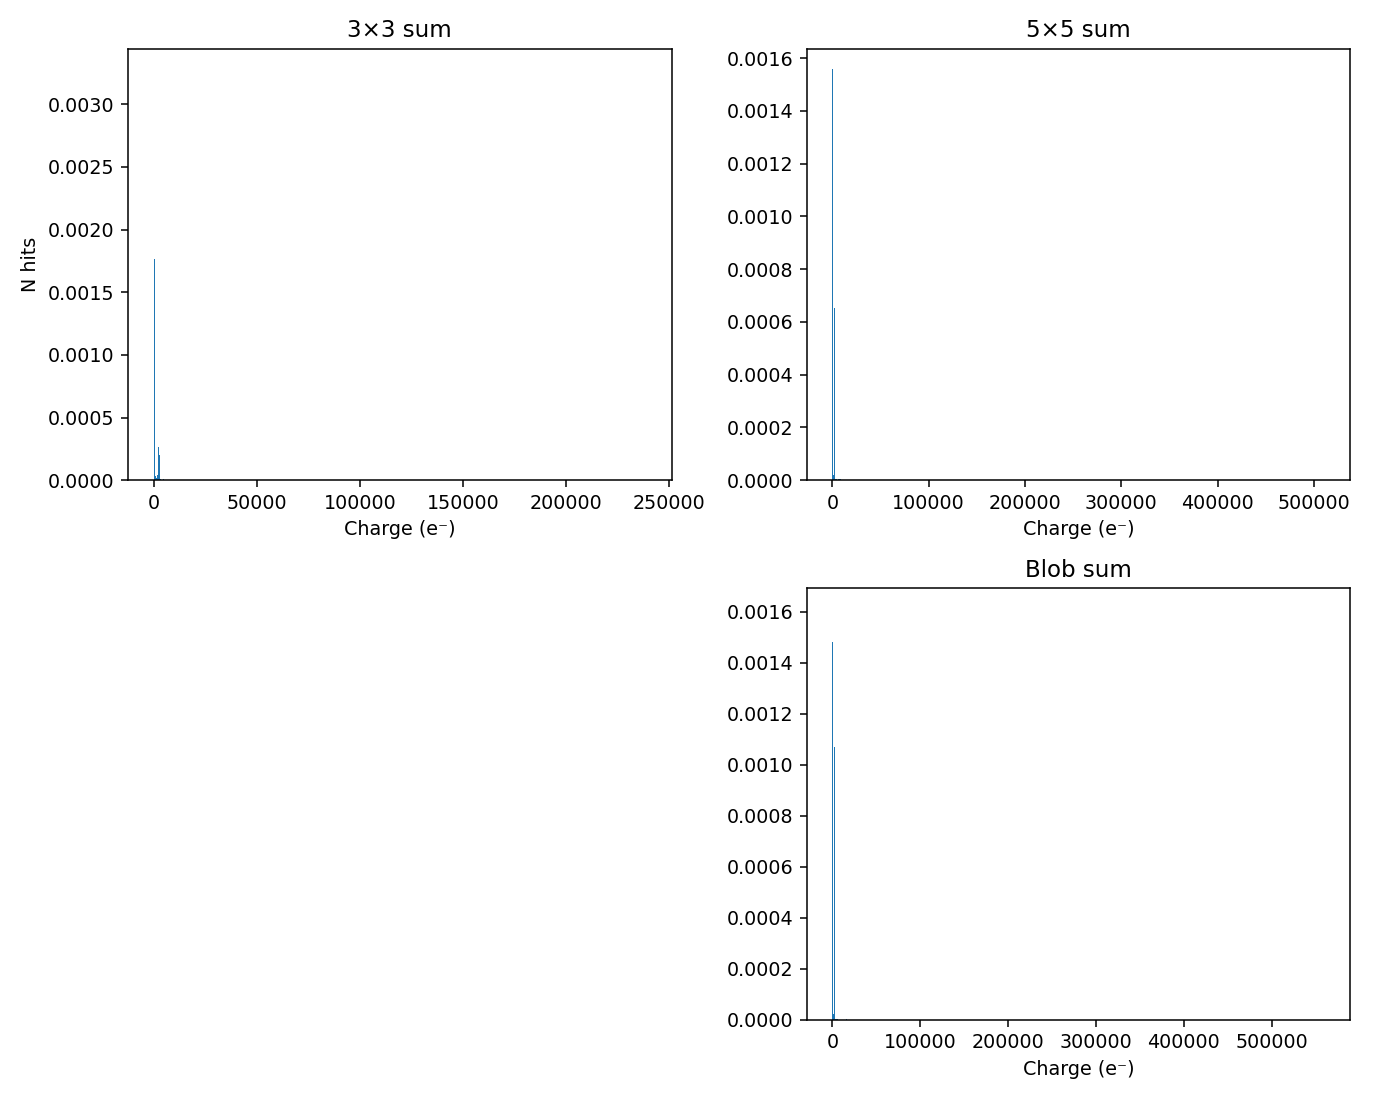

In [13]:
# Plot histograms in 2 rows × 2 cols ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # makes it easy to index: axes[0], axes[1], axes[2], axes[3]

# 3×3 sum
axes[0].hist(df['sum3x3_e⁻'], bins=10000, density = True)
axes[0].set(title='3×3 sum', xlabel='Charge (e⁻)', ylabel='N hits')

# 5×5 sum
axes[1].hist(df['sum5x5_e⁻'], bins=10000, density = True)
axes[1].set(title='5×5 sum', xlabel='Charge (e⁻)')

# Footprint sum
axes[2].axis('off')
#axes[2].hist(df['fp_e⁻'], bins=10000, density = True)
#axes[2].set(title='Footprint sum', xlabel='Charge (e⁻)')

# blob sum
axes[3].hist(df['blob_e⁻'], bins=10000, density = True)
axes[3].set(title='Blob sum', xlabel='Charge (e⁻)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


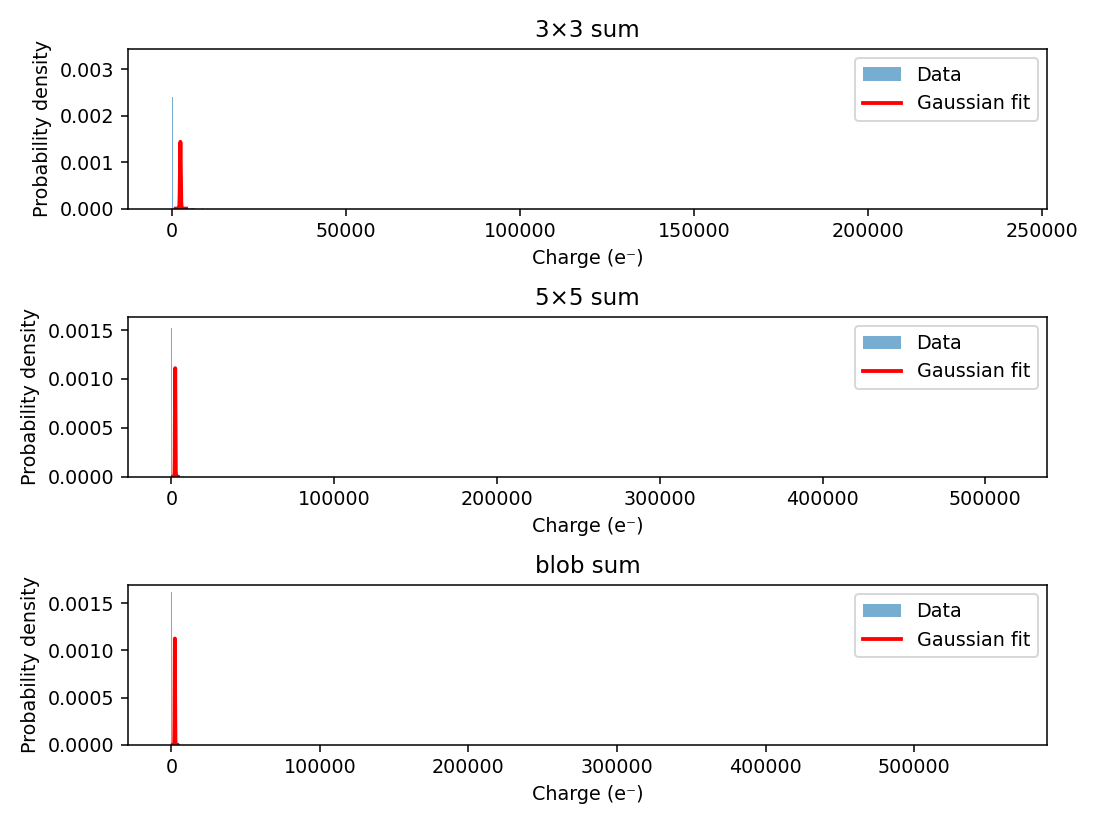

3×3 sum  → μ = 2340.49 e⁻, σ = 124.24 e⁻, FWHM = 292.56 e⁻
5×5 sum  → μ = 2358.06 e⁻, σ = 167.50 e⁻, FWHM = 394.43 e⁻
blob sum → μ = 2357.46 e⁻, σ = 164.57 e⁻, FWHM = 387.54 e⁻


In [20]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)


# prepare a list of (label, data_series) for looping
series = [
    ('3×3 sum', df['sum3x3_e⁻']),
    ('5×5 sum', df['sum5x5_e⁻']),
    ('blob sum', df['blob_e⁻'])
]

# make a figure with two subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
stats = []
# Add your left-hand cut value here (e.g., 1000 e⁻)
cut_left = 1000
cut_right = 4000

for ax, (label, data_series) in zip(axes, series):
    # 1) build histogram
    counts, bin_edges = np.histogram(data_series, bins=10000, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 2) Apply left-hand cut
    mask = (bin_centers >= cut_left) & (bin_centers <= cut_right)
    bin_centers_cut = bin_centers[mask]
    counts_cut = counts[mask]

    # 3) initial guess [A, μ, σ]
    p0 = [counts_cut.max(), data_series.mean(), data_series.std()]
    
    # 4) fit
    popt, _ = curve_fit(gaussian, bin_centers_cut, counts_cut, p0=p0)
    A_fit, mu_fit, sigma_fit = popt
    sigma_fit = abs(sigma_fit)
    
    # 5) FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
    
    # 6) print fit parameters
    print(f"{label:8s} → μ = {mu_fit:.2f} e⁻, σ = {sigma_fit:.2f} e⁻, FWHM = {fwhm:.2f} e⁻")
    stats.append((mu_fit, sigma_fit, fwhm))
    
    # 7) plot histogram + fit
    ax.hist(data_series, bins=10000, density=True, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_centers_cut[0], bin_centers_cut[-1], 2000)
    ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2, label='Gaussian fit')
    ax.set(
        title=label,
        xlabel='Charge (e⁻)',
        ylabel='Probability density'
    )
    ax.legend()

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


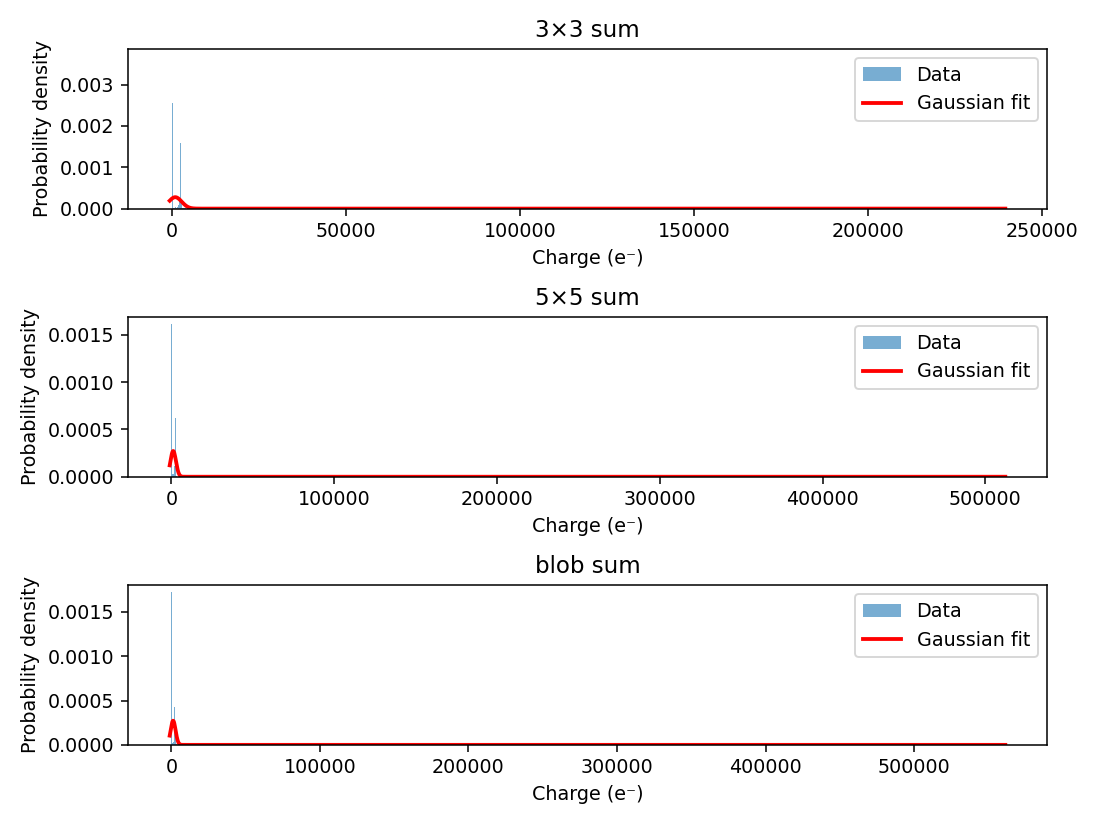

3×3 sum  → μ = 867.64 e⁻, σ = 1856.60 e⁻, FWHM = 4371.96 e⁻
5×5 sum  → μ = 1146.67 e⁻, σ = 1690.96 e⁻, FWHM = 3981.90 e⁻
blob sum → μ = 1191.93 e⁻, σ = 1658.36 e⁻, FWHM = 3905.15 e⁻


In [17]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)


# prepare a list of (label, data_series) for looping
series = [
    ('3×3 sum', df['sum3x3_e⁻']),
    ('5×5 sum', df['sum5x5_e⁻']),
    ('blob sum', df['blob_e⁻'])
]

# make a figure with two subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
stats = []
for ax, (label, data_series) in zip(axes, series):
    # 1) build histogram
    counts, bin_edges = np.histogram(data_series, bins=20000, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 2) initial guess [A, μ, σ]
    p0 = [counts.max(), data_series.mean(), data_series.std()]
    
    # 3) fit
    popt, _ = curve_fit(gaussian, bin_centers, counts, p0=p0)
    A_fit, mu_fit, sigma_fit = popt
    sigma_fit = abs(sigma_fit)
    
    # 4) FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
    
    # 5) print fit parameters
    print(f"{label:8s} → μ = {mu_fit:.2f} e⁻, σ = {sigma_fit:.2f} e⁻, FWHM = {fwhm:.2f} e⁻")
    stats.append((mu_fit,sigma_fit,fwhm))
    # 6) plot histogram + fit
    ax.hist(data_series, bins=20000, density=True, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_edges[0], bin_edges[-1], 2000)
    ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2, label='Gaussian fit')
    ax.set(
        title=label,
        xlabel='Charge (e⁻)',
        ylabel='Probability density'
    )
    ax.legend()

plt.tight_layout()
plt.show()


In [22]:
#finding Fano Factor from raw data and also gaussian fit
# 1) From the raw data:
three_mean_data = df['sum3x3_e⁻'].values.mean()
three_var_data  = df['sum3x3_e⁻'].values.var(ddof=0) 
three_fano_data = (three_var_data / three_mean_data)

five_mean_data = df['sum5x5_e⁻'].values.mean()
five_var_data  = df['sum5x5_e⁻'].values.var(ddof=0)   
five_fano_data = (five_var_data / five_mean_data)

#fp_mean_data = df['fp_e⁻'].values.mean()
#fp_var_data  = df['fp_e⁻'].values.var(ddof=0)    
#fp_fano_data = (fp_var_data / fp_mean_data)

blob_mean_data = df['blob_e⁻'].values.mean()
blob_var_data  = df['blob_e⁻'].values.var(ddof=0)    
blob_fano_data = (blob_var_data / blob_mean_data)

# 2) From the Gaussian fit:
three_mean_fit = stats[0][0]
three_var_fit = stats[0][1]**2
three_fano_fit = (three_var_fit/three_mean_fit)

five_mean_fit = stats[1][0]
five_var_fit = stats[1][1]**2
five_fano_fit = (five_var_fit/five_mean_fit)

blob_mean_fit = stats[2][0]
blob_var_fit  = stats[2][1]**2
blob_fano_fit = (blob_var_fit / blob_mean_fit)

print(f"3x3 Data:   ⟨N⟩ = {three_mean_data:.2f}, Var = {three_var_data:.2f}, Fano = {three_fano_data:.3f}")
print(f"3x3 Fit:    ⟨N⟩ = {three_mean_fit:.2f}, Var = {three_var_fit:.2f}, Fano = {three_fano_fit:.3f}\n")

print(f"5x5 Data:   ⟨N⟩ = {five_mean_data:.2f}, Var = {five_var_data:.2f}, Fano = {five_fano_data:.3f}")
print(f"5x5 Fit:    ⟨N⟩ = {five_mean_fit:.2f}, Var = {five_var_fit:.2f}, Fano = {five_fano_fit:.3f}\n")

print(f"Blob Data:   ⟨N⟩ = {blob_mean_data:.2f}, Var = {blob_var_data:.2f}, Fano = {blob_fano_data:.3f}")
print(f"Blob Fit:    ⟨N⟩ = {blob_mean_fit:.2f}, Var = {blob_var_fit:.2f}, Fano = {blob_fano_fit:.3f}\n")

three_ionization_energy = xray_en / three_mean_fit
five_ionization_energy = xray_en / five_mean_fit
blob_ionization_energy = xray_en / blob_mean_fit

print("Assuming that w = energy deposited / mean number of ionization events = xray energy at peak / mean of distribution = 5.89 keV / ⟨N⟩")
print(f"Estimate of ionization energy using 3x3 sums, w = {three_ionization_energy:.3f} eV / e- \n")
print(f"Estimate of ionization energy using 5x5 sums, w = {five_ionization_energy:.3f} eV / e- \n")
print(f"Estimate of ionization energy using footprint sums, w = {blob_ionization_energy:.3f} eV / e-")

3x3 Data:   ⟨N⟩ = 1574.26, Var = 20763137.72, Fano = 13189.152
3x3 Fit:    ⟨N⟩ = 2340.49, Var = 15435.02, Fano = 6.595

5x5 Data:   ⟨N⟩ = 1699.84, Var = 73652145.30, Fano = 43328.865
5x5 Fit:    ⟨N⟩ = 2358.06, Var = 28056.18, Fano = 11.898

Footprint Data:   ⟨N⟩ = 1829.99, Var = 150332361.93, Fano = 82149.137
Footpring Fit:    ⟨N⟩ = 2357.46, Var = 27084.52, Fano = 11.489

Assuming that w = energy deposited / mean number of ionization events = xray energy at peak / mean of distribution = 5.89 keV / ⟨N⟩
Estimate of ionization energy using 3x3 sums, w = 2.520 eV / e- 

Estimate of ionization energy using 5x5 sums, w = 2.502 eV / e- 

Estimate of ionization energy using footprint sums, w = 2.502 eV / e-


In [25]:
# Define cut range
cut_min = 1000
cut_max = 4000

# Apply cuts to the 3×3 data
data_3x3 = df['sum3x3_e⁻']
data_3x3_cut = data_3x3[(data_3x3 >= cut_min) & (data_3x3 <= cut_max)]

three_mean_data = data_3x3_cut.mean()
three_var_data  = data_3x3_cut.var(ddof=0) 
three_fano_data = three_var_data / three_mean_data

# Apply cuts to the 5×5 data
data_5x5 = df['sum5x5_e⁻']
data_5x5_cut = data_5x5[(data_5x5 >= cut_min) & (data_5x5 <= cut_max)]

five_mean_data = data_5x5_cut.mean()
five_var_data  = data_5x5_cut.var(ddof=0)
five_fano_data = five_var_data / five_mean_data

print(f"3x3 Data:   ⟨N⟩ = {three_mean_data:.2f}, Var = {three_var_data:.2f}, Fano = {three_fano_data:.3f}")
print(f"3x3 Fit:    ⟨N⟩ = {three_mean_fit:.2f}, Var = {three_var_fit:.2f}, Fano = {three_fano_fit:.3f}\n")

print(f"5x5 Data:   ⟨N⟩ = {five_mean_data:.2f}, Var = {five_var_data:.2f}, Fano = {five_fano_data:.3f}")
print(f"5x5 Fit:    ⟨N⟩ = {five_mean_fit:.2f}, Var = {five_var_fit:.2f}, Fano = {five_fano_fit:.3f}\n")

print(f"Blob Data:   ⟨N⟩ = {blob_mean_data:.2f}, Var = {blob_var_data:.2f}, Fano = {blob_fano_data:.3f}")
print(f"Blob Fit:    ⟨N⟩ = {blob_mean_fit:.2f}, Var = {blob_var_fit:.2f}, Fano = {blob_fano_fit:.3f}\n")

3x3 Data:   ⟨N⟩ = 2300.89, Var = 81444.10, Fano = 35.397
3x3 Fit:    ⟨N⟩ = 2340.49, Var = 15435.02, Fano = 6.595

5x5 Data:   ⟨N⟩ = 2316.75, Var = 89947.61, Fano = 38.825
5x5 Fit:    ⟨N⟩ = 2358.06, Var = 28056.18, Fano = 11.898

Blob Data:   ⟨N⟩ = 1829.99, Var = 150332361.93, Fano = 82149.137
Blob Fit:    ⟨N⟩ = 2357.46, Var = 27084.52, Fano = 11.489



In [23]:
best_w = three_ionization_energy
best_f_eff = three_fano_fit

print(f"Best fit of w = {best_w:.3f}")
print(f"Best fit of F_eff = {best_f_eff:.3f}")

Best fit of w = 2.520
Best fit of F_eff = 6.595


[410, 375, 402, 438, 409, 418, 415, 438, 416, 398, 349, 410, 412, 396, 359, 411, 362, 378, 410, 445, 365, 432, 413, 416, 420, 438, 421, 391, 398, 420, 363, 437, 446, 414, 436, 413, 425, 381, 419, 413, 418, 365, 443, 385, 408, 363, 439, 350, 373, 367, 436, 346, 406, 348, 352, 443, 364, 372, 378, 395, 394, 350, 442, 420, 357, 363, 369, 387, 388, 417, 352, 425, 381, 387, 352, 375, 345, 355, 350, 377, 372, 423, 347, 376, 433, 422, 355, 410, 434, 401, 410, 365, 414, 373, 415, 431, 403, 439, 364, 377]


<IPython.core.display.Javascript object>


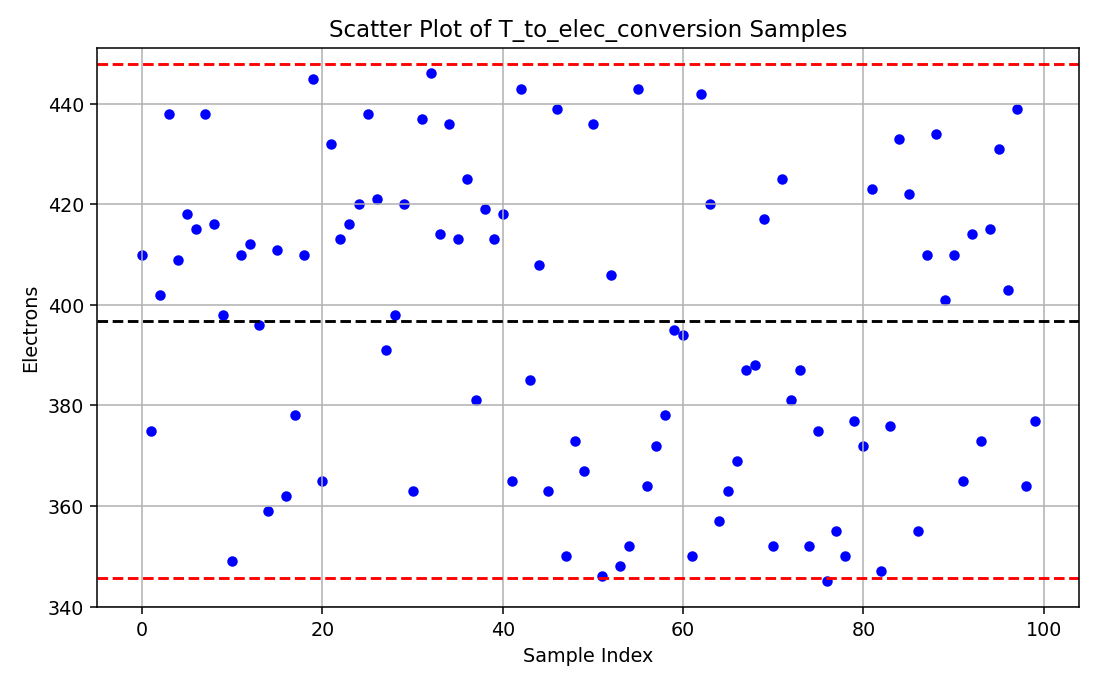

In [26]:
def T_to_elec_conversion(T, f_eff, w):
    return np.random.randint((T/w) - np.sqrt((f_eff*T)/w), high=(T/w) + np.sqrt((f_eff*T)/w), dtype=int)

samples = [T_to_elec_conversion(1000, best_f_eff, best_w) for _ in range(100)]
print(samples)

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(samples)), samples, color='blue', s=20)
plt.axhline(y=1000/best_w, ls='--', color='k')
plt.axhline(y=1000/best_w - np.sqrt((best_f_eff*1000)/best_w), ls='--', color='r')
plt.axhline(y=1000/best_w + np.sqrt((best_f_eff*1000)/best_w), ls='--', color='r')
plt.title('Scatter Plot of T_to_elec_conversion Samples')
plt.xlabel('Sample Index')
plt.ylabel('Electrons')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def T_to_elec_conversion(T, f_eff, w):
    low  = int((T / w) - np.sqrt((f_eff * T) / w))
    high = int((T / w) + np.sqrt((f_eff * T) / w))
    return np.random.randint(low, high, dtype=int)

# Log-spaced T values and sampling
T_values = np.logspace(3, 10, num=20)  # From 1e3 to 1e10
samples_per_T = 100

# Arrays to store results
means = []
stds  = []
T_list = []

for T in T_values:
    samples = np.array([T_to_elec_conversion(T, best_f_eff, best_w) for _ in range(samples_per_T)])
    means.append(samples.mean())
    stds.append(samples.std(ddof=1))
    T_list.append(T)

# Convert to arrays
T_array = np.array(T_list)
means   = np.array(means)
stds    = np.array(stds)

# Plot with error bars and log-log scaling
plt.figure(figsize=(10, 6))
plt.errorbar(T_array, means, yerr=stds, fmt='o', color='navy', alpha=0.7, label='Samples ±1σ')

# Plot expected mean μ = T/w
expected_mean = T_array / best_w
plt.plot(T_array, expected_mean, 'k--', label=r'$\mu = T / w$')

# Log-log scaling
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Deposited Energy T (eV)')
plt.ylabel('Electrons Generated')
#plt.title('Log-Log Plot of Electrons vs. Energy with Error Bars')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
def get_cr_hits_for_frame(df, frame_idx):
    """
    Return a DataFrame of all cosmic-ray hits in a given frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full table with at least a 'frame' column.
    frame_idx : int
        The frame number you want to filter on.

    Returns
    -------
    pandas.DataFrame
        Subset of df where df['frame'] == frame_idx, with a fresh index.
    """
    sub = df[df['frame'] == frame_idx].copy()
    return sub.reset_index(drop=True)

# Suppose df is your full CR-hit table:
inspect_frame = 61
hits_from_frame = get_cr_hits_for_frame(df, inspect_frame)
print(hits_from_frame)


     frame     y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  fp_label  \
0       61    10  2333       1485  2410.4520       1451  2355.2632        10   
1       61    15   100       1351  2192.9432       1293  2098.7976        22   
2       61    39  4022       1447  2348.7704       1431  2322.7992        60   
3       61   148  2718       1458  2366.6256       1517  2462.3944       188   
4       61   172   631       1227  1991.6664       1283  2082.5656       210   
..     ...   ...   ...        ...        ...        ...        ...       ...   
213     61  3942  3038       1451  2355.2632       1450  2353.6400      6034   
214     61  3963  1607       1409  2287.0888       1444  2343.9008      6187   
215     61  4058  1362       1318  2139.3776       1321  2144.2472      6740   
216     61  4070  2485       1393  2261.1176       1348  2188.0736      6780   
217     61  4086  1624       1330  2158.8560       1276  2071.2032      6819   

     fp_DN      fp_e⁻  n_pix_fp  
0    

<IPython.core.display.Javascript object>


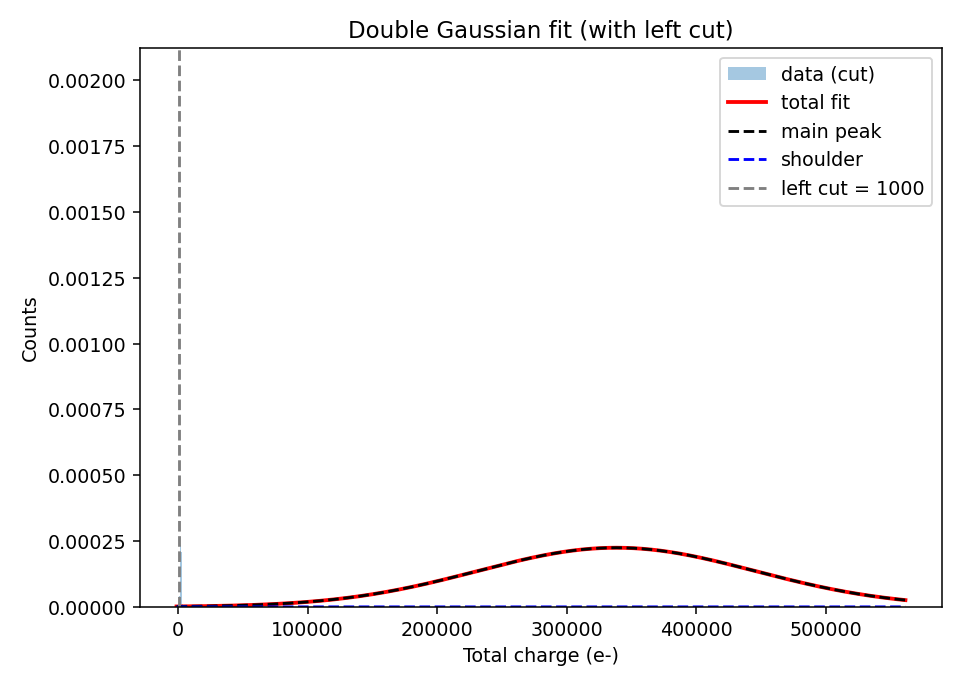

Total fit FWHM = 252131.67 e-


In [29]:
blob_data = df["blob_e⁻"].to_numpy()


left_cut = 1000
right_cut = 4000

def double_gauss(x, A1, μ1, σ1, A2, μ2, σ2):
    g1 = A1 * np.exp(-0.5*((x-μ1)/σ1)**2)
    g2 = A2 * np.exp(-0.5*((x-μ2)/σ2)**2)
    return g1 + g2

# 1) Histogram and left cut
counts, edges = np.histogram(blob_data, bins=5000, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])
maskk = (bin_centers >= cut_left) & (bin_centers <= cut_right)
counts_cut = counts[mask]
centers_cut = centers[mask]

# 2) Initial guess
p0 = [
    counts_cut.max(), centers_cut.mean(), centers_cut.std(),
    counts_cut.max() / 4, centers_cut.mean() + 2 * centers_cut.std(), centers_cut.std()
]

# 3) Fit
popt, _ = opt.curve_fit(double_gauss, centers_cut, counts_cut, p0=p0,
                        bounds=([0, -np.inf, 0, 0, -np.inf, 0],
                                [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))

σ_main = abs(popt[2])
fwhm_main = 2 * np.sqrt(2 * np.log(2)) * σ_main

# 4) Plotting
x = np.linspace(edges[0], edges[-1], 5000)
plt.figure(figsize=(7, 5))
plt.hist(blob_data[blob_data >= left_cut], bins=5000, density=True, alpha=0.4, label="data (cut)")
plt.plot(x, double_gauss(x, *popt), 'r-', lw=2, label="total fit")
plt.plot(x, popt[0] * np.exp(-0.5 * ((x - popt[1]) / popt[2])**2), 'k--', label="main peak")
plt.plot(x, popt[3] * np.exp(-0.5 * ((x - popt[4]) / popt[5])**2), 'b--', label="shoulder")
plt.axvline(left_cut, color='gray', linestyle='--', label=f'left cut = {left_cut}')
plt.legend()
plt.xlabel('Total charge (e-)')
plt.ylabel('Counts')
plt.title("Double Gaussian fit (with left cut)")
plt.tight_layout()
plt.show()

# 5) FWHM calculation from total fit
x_fit = np.linspace(edges[0], edges[-1], 5000)
y_fit = double_gauss(x_fit, *popt)
y_max = y_fit.max()
y_half = y_max / 2.0
idx_peak = np.argmax(y_fit)

# Left FWHM point
i = idx_peak
while i > 0 and y_fit[i] > y_half:
    i -= 1
x_left = x_fit[i] + (y_half - y_fit[i]) * (x_fit[i + 1] - x_fit[i]) / (y_fit[i + 1] - y_fit[i])

# Right FWHM point
j = idx_peak
while j < len(y_fit) - 1 and y_fit[j] > y_half:
    j += 1
x_right = x_fit[j - 1] + (y_half - y_fit[j - 1]) * (x_fit[j] - x_fit[j - 1]) / (y_fit[j] - y_fit[j - 1])

fwhm_total = x_right - x_left
print(f"Total fit FWHM = {fwhm_total:.2f} e-")


Original dataframe had  20852  candidate entries
New dataframe has  20736  candidate entries, 116  were duplicates


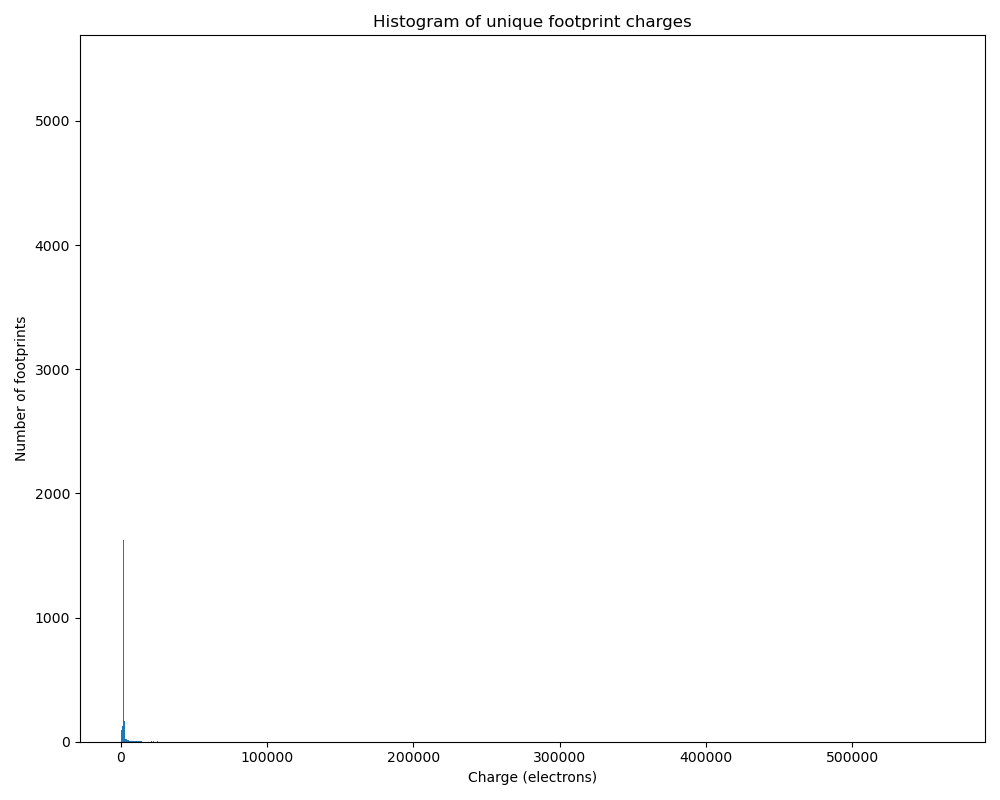

In [37]:
df_unique = df.drop_duplicates(subset=['frame','fp_label'])

# define your desired x– and y–limits
x_min, x_max = 0, 6000
y_min, y_max = 0, 500

print("Original dataframe had ",len(df)," candidate entries")
difference = len(df) - len(df_unique)
print("New dataframe has ",len(df_unique)," candidate entries,", difference, " were duplicates")

plt.figure(figsize=(10,8))
plt.hist(df_unique['fp_e⁻'], bins=5000)
plt.xlabel('Charge (electrons)')
plt.ylabel('Number of footprints')
plt.title('Histogram of unique footprint charges')
plt.tight_layout()
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
plt.show()


In [44]:
# assume `events` is your (N,3) array of (frame, y, x)
# and `maskArray` is your final boolean bad‐pixel mask

# get a boolean for each event: True if it sits on a masked pixel
on_bad = [maskArray[y, x] for _, y, x in events]

# extract the offending events
bad_events = events[on_bad]

print(f"{len(bad_events)} of {len(events)} total events fall directly on a 'bad' pixel.")

# maybe look at the first few to inspect
print(bad_events[:10])


0 of 20852 total events fall directly on a 'bad' pixel.
[]


In [46]:
print(labels_fp)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [48]:
labels_fp = labels_list[inspect_frame]


In [49]:
# which footprint‐labels still survive in `events`?
evt_labs = [ labels_fp[y, x] for (_f,y,x) in events if _f==inspect_frame ]
print("Labels with centroids:", sorted(set(evt_labs)))
print("All labels drawn:",     sorted(set(np.unique(labels_fp)) - {0}))


Labels with centroids: [10, 22, 60, 188, 210, 223, 255, 271, 278, 355, 378, 381, 452, 454, 461, 478, 500, 526, 542, 544, 546, 563, 598, 617, 642, 665, 673, 679, 680, 697, 725, 728, 747, 760, 808, 818, 821, 835, 838, 846, 847, 857, 893, 895, 942, 946, 950, 961, 970, 977, 1003, 1021, 1036, 1062, 1083, 1106, 1148, 1152, 1194, 1205, 1274, 1279, 1312, 1329, 1352, 1359, 1389, 1428, 1465, 1471, 1498, 1501, 1507, 1561, 1569, 1591, 1598, 1647, 1673, 1686, 1708, 1762, 1804, 1807, 1812, 1837, 1867, 1880, 1989, 2012, 2040, 2087, 2104, 2116, 2127, 2144, 2173, 2182, 2191, 2202, 2219, 2229, 2271, 2299, 2316, 2327, 2355, 2364, 2422, 2478, 2511, 2547, 2557, 2625, 2643, 2656, 2665, 2669, 2671, 2674, 2695, 2734, 2772, 2803, 2805, 2812, 2821, 2858, 2861, 2885, 2913, 2950, 2973, 3056, 3064, 3073, 3107, 3139, 3242, 3278, 3334, 3336, 3350, 3433, 3495, 3555, 3579, 3625, 3648, 3657, 3677, 3722, 3792, 3808, 3889, 3942, 3956, 3973, 4080, 4104, 4189, 4192, 4208, 4222, 4235, 4241, 4261, 4306, 4307, 4339, 4342, 438

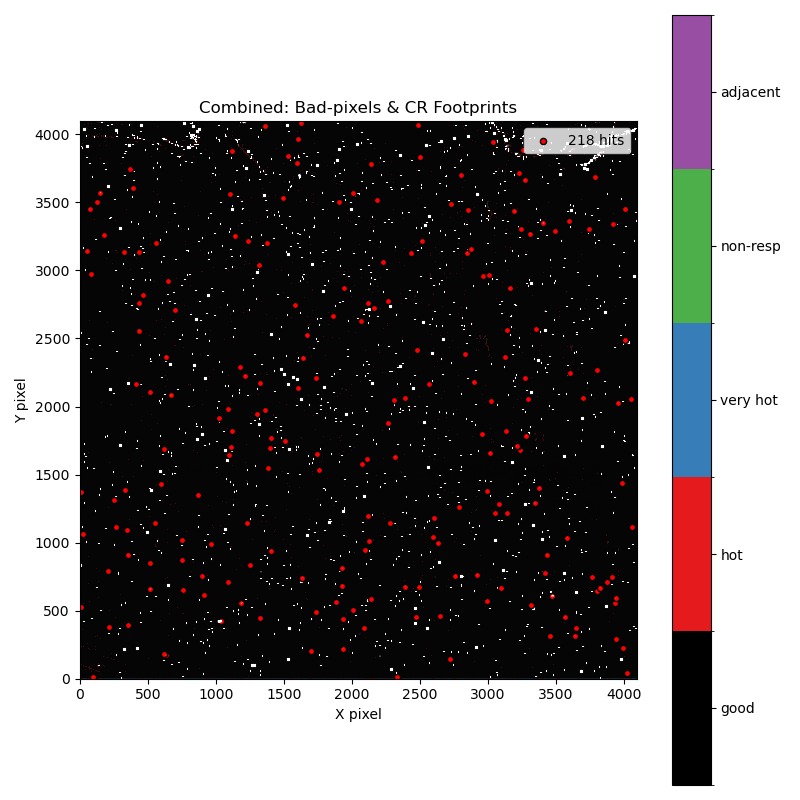

In [43]:
from matplotlib import patches
inspect_frame = 61

# 0) grab the image and build your RGB mask as before
img       = data[inspect_frame]
labels_fp = labels_list[inspect_frame]   # your 2D label map for this frame

# → new: extract centroids for this frame from your events array
mask_frame = (events[:,0] == inspect_frame)
ys, xs     = events[mask_frame, 1], events[mask_frame, 2]

# 1) build the integer label map for bad-pixel classes
labels = np.zeros((h, w), dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

# 2) prepare a ListedColormap + BoundaryNorm for classes 0–4
cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 = good pixels (black)
    "#e41a1c",  # 1 = hot         (red)
    "#377eb8",  # 2 = very hot    (blue)
    "#4daf4a",  # 3 = non-resp    (green)
    "#984ea3",  # 4 = adjacent    (purple)
])
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

# 3) single axes figure
fig, ax = plt.subplots(figsize=(8, 8))

# — plot bad-pixel classification as the base layer
im = ax.imshow(labels, origin='lower', cmap=cmap, norm=norm)

# — overlay grayscale image semi-transparent
ax.imshow(img, cmap='gray', origin='lower', alpha=0.5)

# — overlay RGB mask semi-transparent
ax.imshow(rgb_mask, origin='lower', alpha=0.5)

# — draw contours (or tiny rectangles for 1×1) around each CR footprint
for lab in np.unique(labels_fp):
    if lab == 0:
        continue
    ys_lab, xs_lab = np.where(labels_fp == lab)
    y0, y1 = ys_lab.min(), ys_lab.max()
    x0, x1 = xs_lab.min(), xs_lab.max()
    height, width = (y1 - y0 + 1), (x1 - x0 + 1)

    if height >= 2 and width >= 2:
        region = (labels_fp[y0:y1+1, x0:x1+1] == lab).astype(int)
        ax.contour(
            region, levels=[0.5],
            colors='white', linewidths=1.5,
            origin='lower',
            extent=(x0, x1+1, y0, y1+1)
        )
    else:
        rect = patches.Rectangle(
            (x0, y0), width, height,
            linewidth=1.5, edgecolor='white', facecolor='none'
        )
        ax.add_patch(rect)

# — plot centroids on top
ax.scatter(xs, ys, s=20, c='red', edgecolor='black',
           label=f"{len(xs)} hits")

# — add a colorbar for the bad-pixel classes
cbar = fig.colorbar(im, ax=ax, ticks=[0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels([
    "good", "hot", "very hot", "non-resp", "adjacent"
])

# — finish styling
ax.legend(loc='upper right')
ax.set_xlim(0, w)
ax.set_ylim(0, h)
ax.set_title("Combined: Bad-pixels & CR Footprints")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")

plt.tight_layout()
plt.show()

In [ ]:
# 1) Build df_unique (one row per footprint)
#    Make sure your original df has a column 'fp_label'
#df_unique = df.drop_duplicates(subset=['frame','fp_label'])

# 2) Compute centroids of each footprint
centroids = (
    df_unique
      .groupby(['frame','fp_label'])
      .agg(x_centroid=('x','mean'),
           y_centroid=('y','mean'))
      .reset_index()
)

In [ ]:
# 1) Using direct indexing
#df_filtered = df[df['n_pix_fp'] > 10]

# 2) Using .loc
#df_filtered = df.loc[df['n_pix_fp'] > 10]

# 3) Using .query
#df_filtered = df.query('n_pix_fp > 10')

#df_filtered = df_filtered.reset_index(drop=True)

# 1a) filter and copy
df_filtered = df_unique[df_unique['n_pix_fp'] > 10].copy()

# 1b) now it’s safe to sort in place
df_filtered.sort_values('n_pix_fp', ascending=False, inplace=True)

# (optional) reset index
#df_filtered.reset_index(drop=True, inplace=True)
df_filtered.head(20)

In [ ]:
inspect_frame = 61

# 3) Select only this frame’s footprints
sel = centroids['frame'] == inspect_frame
frame_centroids = centroids.loc[sel]

# 4) Grab image & RGB mask
img = data[inspect_frame]

rgb_mask = np.zeros((h, w, 3), dtype=float)
rgb_mask[..., 0] = mask_med.astype(float)
rgb_mask[..., 1] = mask0.astype(float)
rgb_mask[..., 2] = mask_sat.astype(float)

# 5) Fetch precomputed background & labels
median    = medians[inspect_frame]
labels_fp = labels_list[inspect_frame]

# 6) Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img,      cmap='gray', origin='lower')
ax.imshow(rgb_mask, origin='lower', alpha=0.5)

# contours of each unique footprint
for lab in frame_centroids['fp_label']:
    if lab == 0:
        continue
    region = (labels_fp == lab)
    ax.contour(
        region.astype(int),
        levels=[0.5],
        colors='white',
        linewidths=1.5,
        origin='lower'
    )

# scatter the centroids
ax.scatter(
    frame_centroids['x_centroid'],
    frame_centroids['y_centroid'],
    s=40,
    facecolors='none',
    edgecolors='red',
    label=f"{len(frame_centroids)} footprints"
)

ax.set_title(f"Frame {inspect_frame}: unique full-footprint outlines")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()
